In [43]:
import os
import time
import twint 
import datetime
import numpy as np
import tweepy as tw
import pandas as pd
import seaborn as sns
import yfinance as yf
import configparser as cp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request

# Downloading historical data

In [2]:
stock = yf.Ticker("TATAMOTORS.NS")
df = stock.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-12-25,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-26,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-27,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-28,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0
1995-12-29,53.472778,53.472778,53.472778,53.472778,0,0.0,0.0


In [3]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-17,436.000000,442.450012,436.000000,439.899994,6955445,0.0,0.0
2023-02-20,441.799988,445.299988,436.250000,443.000000,9717197,0.0,0.0
2023-02-21,445.200012,445.200012,435.250000,436.500000,8957930,0.0,0.0
2023-02-22,435.299988,435.850006,428.250000,429.450012,7209130,0.0,0.0
2023-02-23,428.649994,436.450012,427.200012,433.200012,9278237,0.0,0.0


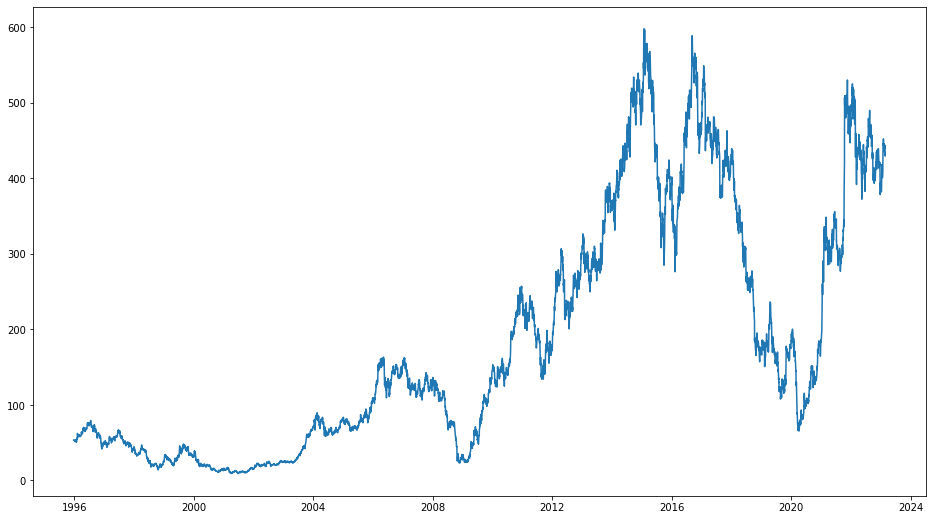

In [4]:
plt.figure(figsize = (16, 9))
plt.plot(df["Close"])

In [5]:
#Saving the historical data for tata motors
df.to_csv("../data/TATAMOTORS.csv")

# Downloading sentiment data

In [4]:
config = cp.RawConfigParser()
config.read(filenames = '/path/twitter.txt')

# Path: notebooks\data-collection.ipynb
config.read("../data/twitter.ini")
API_KEY = config.get("twitter", "API_KEY")
API_SECRET = config.get("twitter", "API_SECRET_KEY")
ACCESS_TOKEN = config.get("twitter", "ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = config.get("twitter", "ACCESS_TOKEN_SECRET")

In [5]:
auth = tw.OAuthHandler(API_KEY, API_SECRET) 
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET) 
api = tw.API(auth,wait_on_rate_limit=True)

datetime.date(1995, 12, 25)

In [87]:
def get_tweets(hashtag_phrase):
    format_hashtag = '#'+hashtag_phrase
    start_date = datetime.date.today() - datetime.timedelta(days=6)
    end_date = datetime.date.today()
    consumer_key = API_KEY
    consumer_secret = API_SECRET
    access_token = ACCESS_TOKEN
    access_token_secret = ACCESS_TOKEN_SECRET

    auth = tw.OAuthHandler(consumer_key,
                                consumer_secret)
    auth.set_access_token(access_token,access_token_secret)
    api = tw.API(auth)
    twitter_posts = pd.DataFrame(columns=['timestamp', 'tweet_text',
                                            'followers_count'])
    timestamp=[]
    tweets=[]
    follow_count=[]
    for tweet in tw.Cursor(api.search_tweets, q=format_hashtag+' - filter:retweets', lang="en", tweet_mode='extended').items():
        timestamp.append(tweet.created_at)
        tweets.append(tweet.full_text.replace('\n',' ').encode('utf-8'))
        follow_count.append(tweet.user.followers_count)
        twitter_posts['timestamp'] = tweet.created_at
        twitter_posts['tweet_text']= tweet.full_text.replace('\n',' ').encode('utf-8')
        twitter_posts['followers_count']= tweet.user.followers_count
        twitter_posts['tweet_text']=twitter_posts['tweet_text'].str.decode("utf-8")
        # twitter_posts['scaled_followers_count']=twitter_posts['followers_count']/twitter_posts['followers_count'].max()
        # twitter_posts['compound'] = twitter_posts['compound']*(twitter_posts['scaled_followers_count']+1)
        twitter_posts.to_csv('../data/twitter-data/' + hashtag_phrase + '_' + (datetime.date.today().strftime('%Y-%m-%d')) + '.csv')

    return twitter_posts

In [88]:
def get_news(ticker_code):
    # 1. Define URL:
    finwiz_url = 'https://finviz.com/quote.ashx?t='
    # 2. Requesting data:
    news_tables = {}
    tickers = [ticker_code]
    for ticker in tickers:
        url = finwiz_url + ticker
        req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'})
        response = urlopen(req)
        html = BeautifulSoup(response)
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table
    #3. Parsing news:
    parsed_news = []
    for file_name, news_table in news_tables.items():
        for x in news_table.findAll('tr'):
            text = x.a.get_text()
            date_scrape = x.td.text.split()
            if len(date_scrape) == 1:
                time = date_scrape[0]
                date = date_scrape[0]
                time = date_scrape[1]
            ticker = file_name.split('_')[0]
            parsed_news.append([ticker, date, time, text])
    parsed_news.to_csv('PATH' + ticker + '_data_' + (datetime.date.today().strftime('%Y-%m-%d-%H')) + '.csv')

In [89]:
get_tweets("TataMotors")

,timestamp,tweet_text,followers_count
